# Problem Statement
The classification of clients applying for loan into bad clients and good clients with respect to the various details regarding the client provided to the bank so the bank could make informative decision to avoid risk of non-repayment of loan and hence reduce liquid damage to the bank.<br>

1. Month: Month of loan applied (1-12) 
2. Credit Amount: Balance Amount 
3. Credit Term: No.of months due
4. Age: Age of the client
5. Sex : Gender (Male/Female)
6. Education: Types  of education 
7. Product type: Type of product for loan
8. Having_children: If the client has children (0/1)
9. Region: Region from which client comes from 
10. Income: Monthly Salary of the client
11. Family_status: Whether the client is married or not.
12. Phone operator: Type of phone operator used.
13. Is_client: Has an existing loan

The dependent/target variable is:
14. Bad_client: The client is considered a bad client to give a loan to. Good client (0) or bad client (1)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, cohen_kappa_score, accuracy_score, roc_auc_score, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [3]:
plt.rcParams['figure.figsize'] = [15,8]

In [4]:
client = pd.read_csv('clients.csv')

# Preliminary Investigation

In [5]:
 client.head()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


In [6]:
 client.tail()

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
1718,12,18500,6,32,male,Higher education,Cell phones,1,2,46000,Another,1,1,0
1719,12,6500,6,24,male,Secondary special education,Cell phones,0,2,18000,Another,0,1,0
1720,12,5500,12,21,male,Incomplete higher education,Cell phones,0,2,15000,Another,1,1,0
1721,12,30500,10,25,female,Incomplete higher education,Cell phones,0,2,41000,Another,2,1,1
1722,12,116000,24,34,male,Higher education,Clothing,1,2,41000,Another,2,0,0


In [7]:
client.shape

(1723, 14)

**Comments:**<br>
Total 1723 records, 13 features and 1 target variable

In [8]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


Comments
1. There are 10 numerical columns
2. And 4 categorical columns

In [9]:
client['month'] = client['month'].astype('O')
client['credit_term'] = client['credit_term'].astype('O')
client['having_children_flg'] = client['having_children_flg'].astype('O')
client['region'] = client['region'].astype('O')
client['phone_operator'] = client['phone_operator'].astype('O')
client['phone_operator'] = client['phone_operator'].astype('O')
client['is_client'] = client['is_client'].astype('O')

In [10]:
client.describe()

,credit_amount,age,income,bad_client_target
count,1723.000000,1723.000000,1723.000000,1723.000000
mean,29264.654672,35.911782,32652.350551,0.113755
std,27926.778301,13.120203,20913.193158,0.317606
min,5000.000000,18.000000,1000.000000,0.000000
25%,13000.000000,26.000000,21000.000000,0.000000
50%,21500.000000,32.000000,27000.000000,0.000000
75%,34000.000000,44.000000,38000.000000,0.000000
max,301000.000000,90.000000,401000.000000,1.000000


**Comments**
1. Credit card is positiveky skewed.
2. Age is near normally distributed.
3. Income is also positiveky skewed.
4. Target variable is skewed as well.<br>
`Need for scaling`

# Exploratory Data Analysis

## 1. Target Distribution

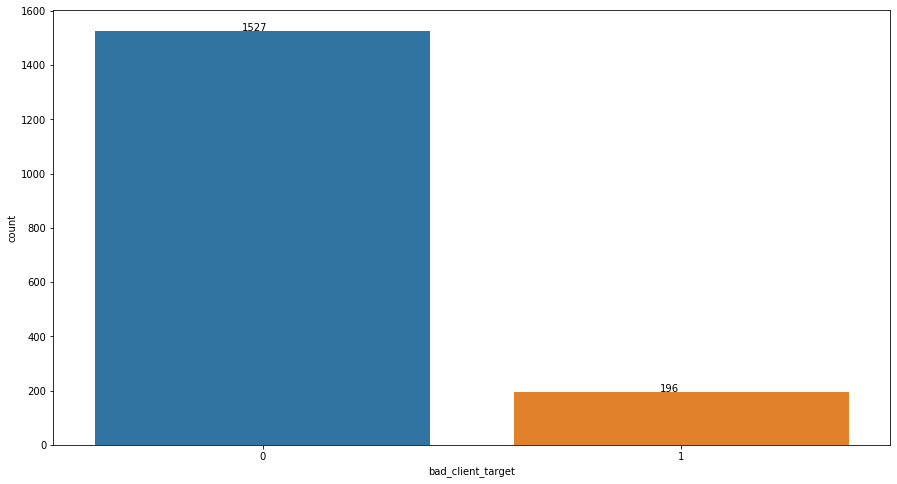

In [12]:
sns.countplot(x='bad_client_target', data=client)
plt.text(x = -0.05, y = client['bad_client_target'].value_counts()[0] + 1, s = str(client['bad_client_target'].value_counts()[0]) )
plt.text(x = 0.95, y = client['bad_client_target'].value_counts()[1] +1, s = str(client['bad_client_target'].value_counts()[1]) )
plt.show()

In [13]:
df_num = client.select_dtypes(np.number)
df_num.drop(columns=['bad_client_target'], inplace=True)
df_num.columns

Index(['credit_amount', 'age', 'income'], dtype='object')

In [14]:
df_cat = client.select_dtypes(include='object')
df_cat.columns

Index(['month', 'credit_term', 'sex', 'education', 'product_type',
       'having_children_flg', 'region', 'family_status', 'phone_operator',
       'is_client'],
      dtype='object')

## 2. Univariate analysis of Categorical features

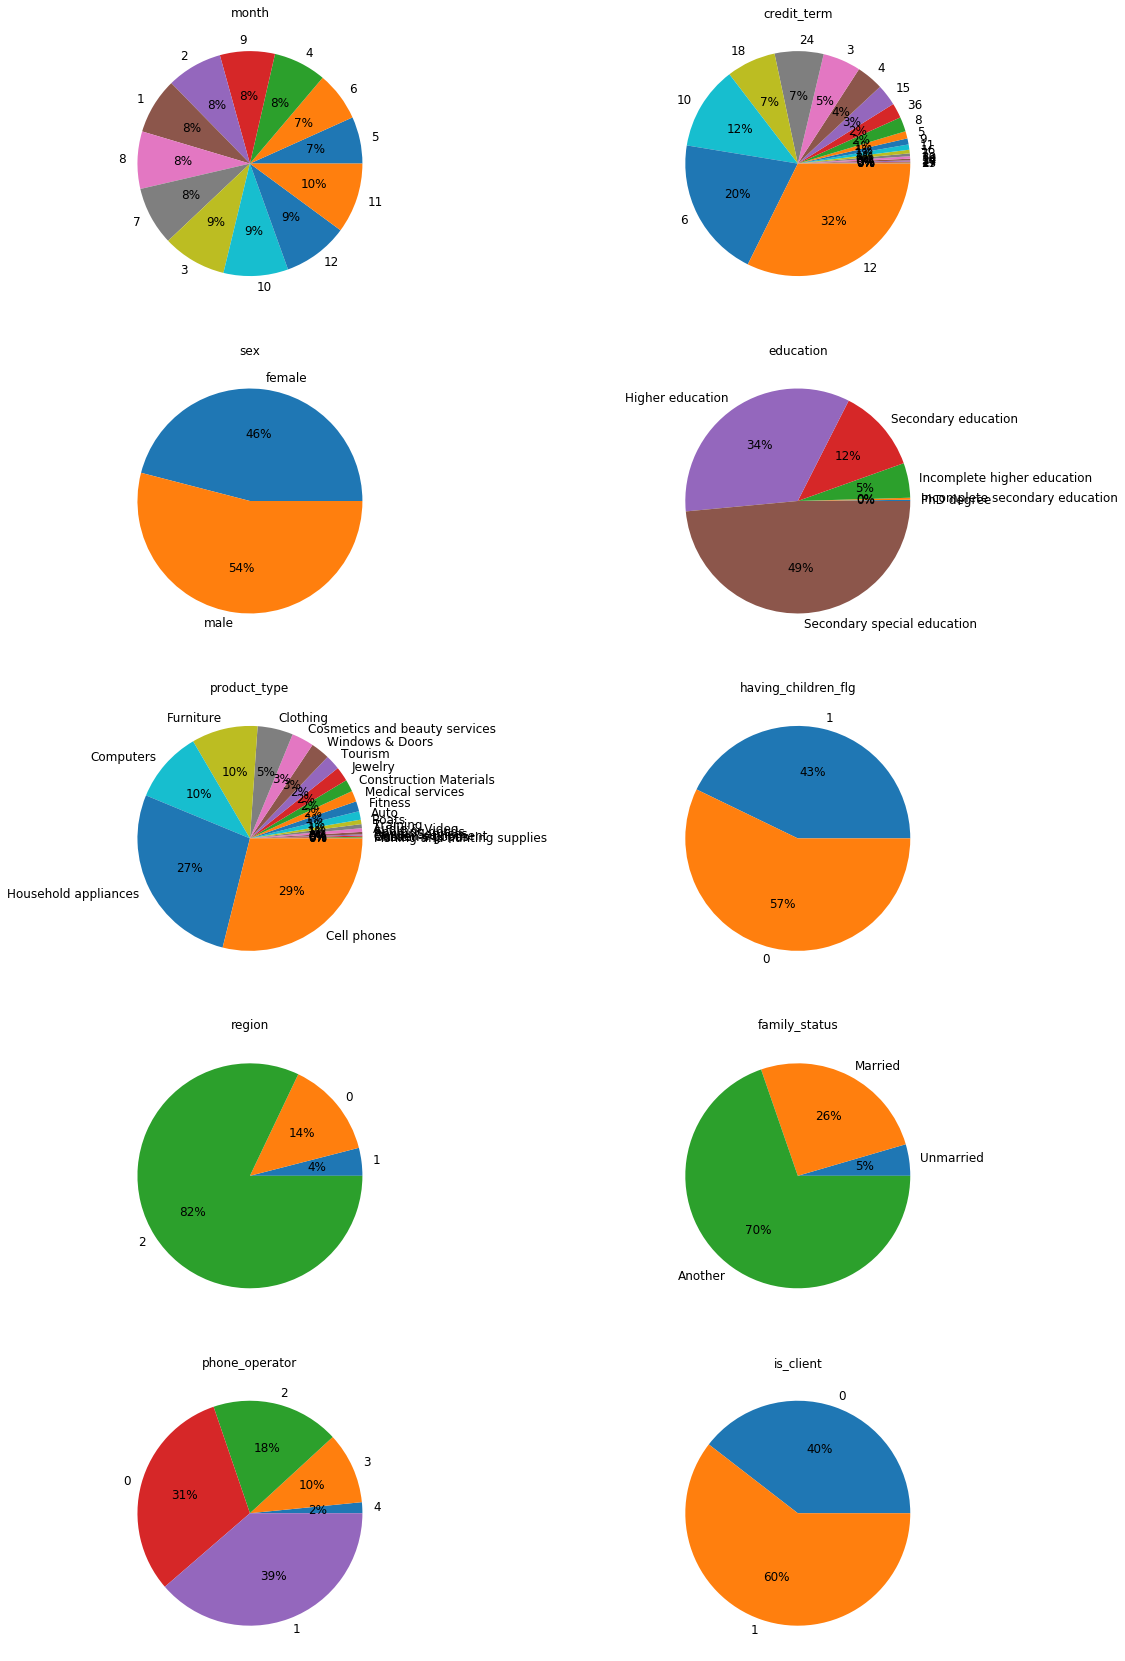

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(18,30))
axes = [ax for axes_rows in axes for ax in axes_rows]

for i, c in enumerate(df_cat.columns):
    client[c].value_counts()[::-1].plot(kind='pie',
                                          ax=axes[i],
                                          title=c,
                                          autopct='%.0f%%',
                                          fontsize=12)
    axes[i].set_ylabel('')

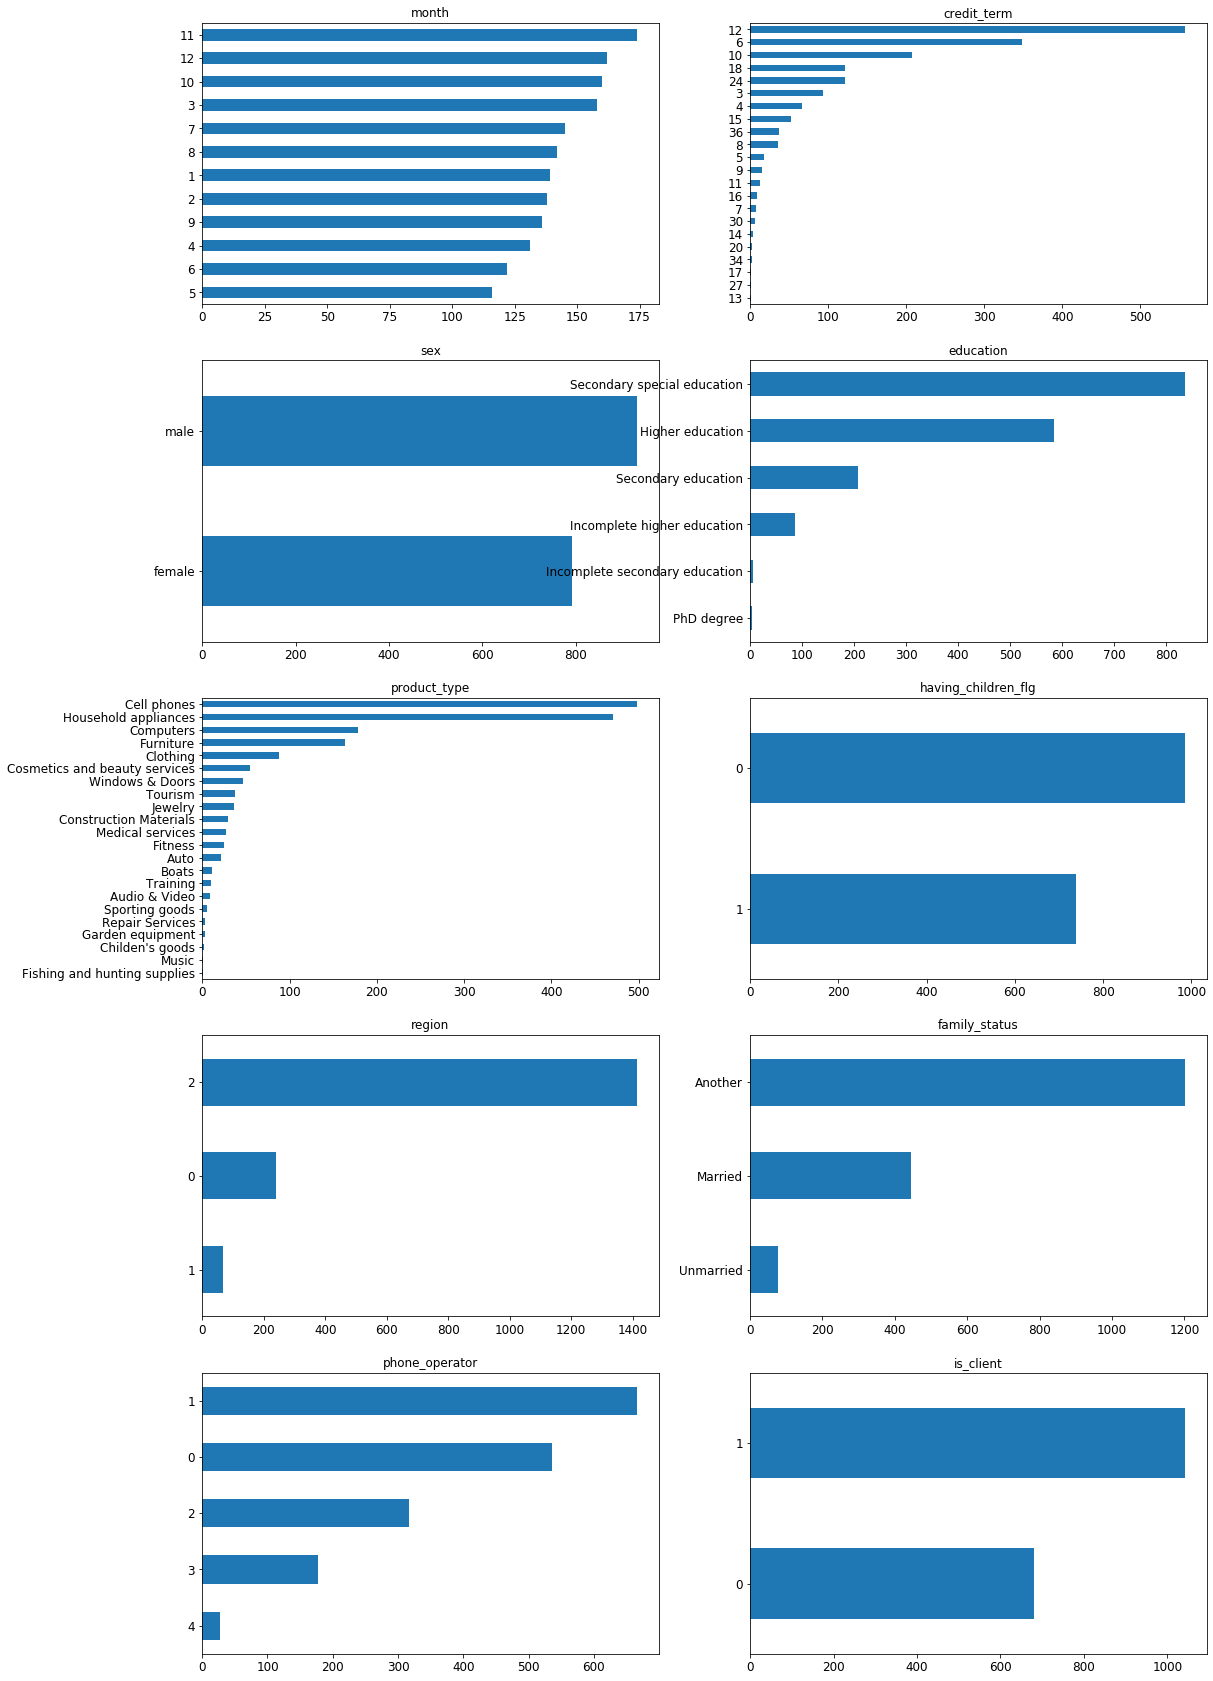

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(18,30))
axes = [ax for axes_rows in axes for ax in axes_rows]

for i, c in enumerate(df_cat.columns):
    client[c].value_counts()[::-1].plot(kind='barh',
                                          ax=axes[i],
                                          title=c,
                                          fontsize=12)

**Comments**
1. More number of clients during the end of the calender year.
2. Highest No.of months due (credit term) is 12.
3. Male and Female ratio is also equal.
4. Most of the loan applicants are highly educated.
5. Surprisingly, more than 60% of the loan taken are for non essential items like cell phone, home appliances and computers and very less for essential types like medical.
6. More than 80% of the customers are from region 2. Need to focus more on region 1 and 0.

## 3. Bivariate analysis of Categorical features

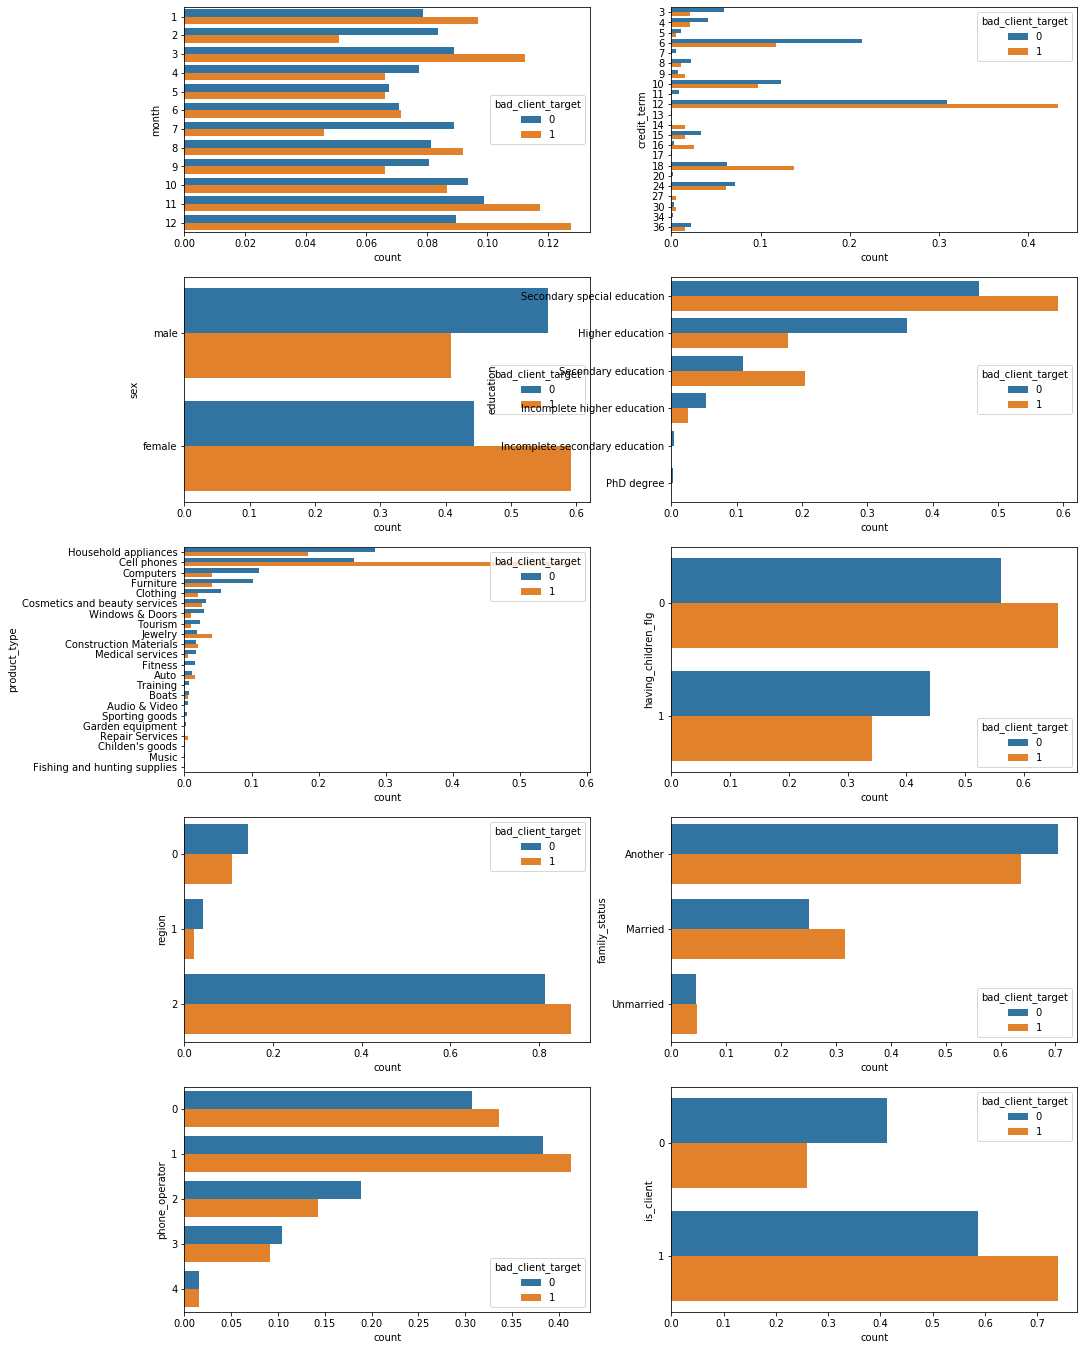

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(16,24))
axes = [ax for axes_rows in axes for ax in axes_rows]

for i, c in enumerate(df_cat.columns):
    fltr = client['bad_client_target']==0
    
    vc_a=client[fltr][c].value_counts(normalize=True).reset_index().rename({'index':c,c:'count'}, axis=1)
    
    vc_b=client[~fltr][c].value_counts(normalize=True).reset_index().rename({'index':c,c:'count'}, axis=1)
    
    vc_a['bad_client_target']=0
    vc_b['bad_client_target']=1
    
    df = pd.concat([vc_a, vc_b]).reset_index(drop=True)
    
    sns.barplot(y=c, x='count', data=df, hue='bad_client_target', ax=axes[i], orient='h')

**Comments**
1. Most of the client who applied loan in the begining or end of the year are bad clients.
2. Credit term's with multiples of 6 i.e, half yearly, yearly and one and a half yearly have high number of bad clients.
3. High no. of bad clients are females.
4. Surprisingly, highly educated clients are more bad clients.
5. Loan application for cell phone attract more no.of bad clients.

## 4. Univariate analysis of Numerical features

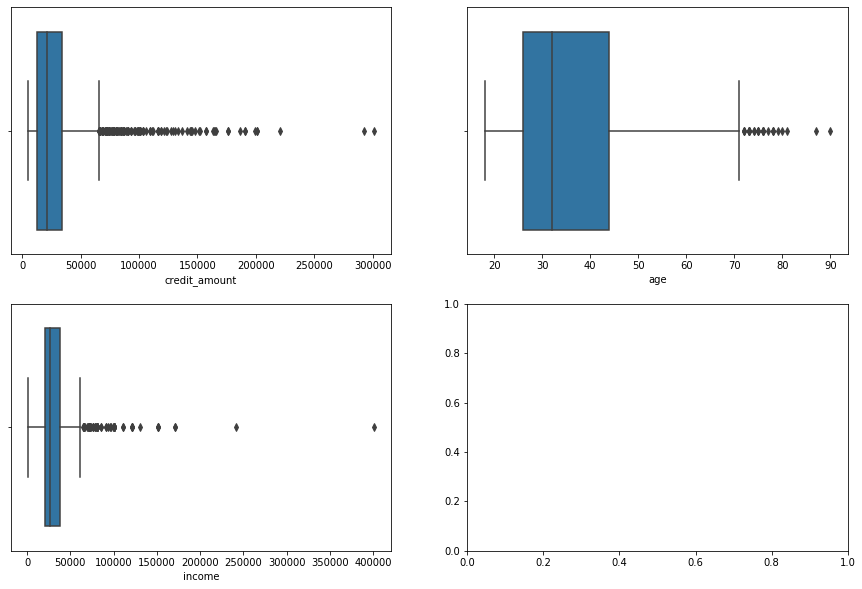

In [18]:
fig, axes = plt.subplots(2, 2,figsize=(15,10))
y = 0
for c in df_num.columns:
    i, j = divmod(y, 2)
    if c!='bad_client_target':
        sns.boxplot(x = c, data=client, orient='h', ax=axes[i, j])
        y = y + 1

**Comments**<br>
Credit amount and income have highest no.of outliers on the positive side, meaning, more variations in high income clients. 

## 5. Bivariate analysis of Numerical features

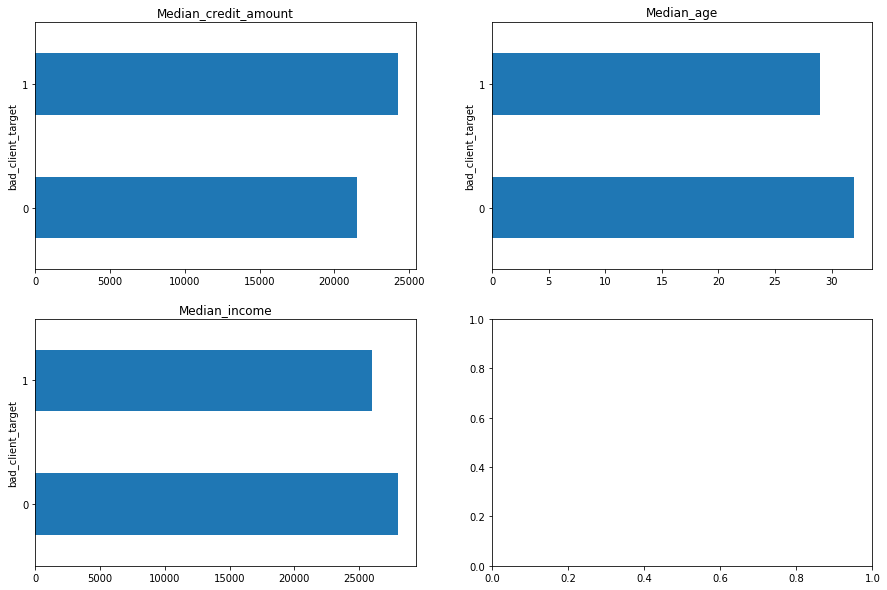

In [19]:
#sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(df_num):
    client.groupby('bad_client_target')[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])

## 6. Correlation analysis

In [20]:
client['month'] = client['month'].astype('int64')
client['credit_term'] = client['credit_term'].astype('int64')
client['having_children_flg'] = client['having_children_flg'].astype('int64')
client['region'] = client['region'].astype('int64')
client['phone_operator'] = client['phone_operator'].astype('int64')
client['phone_operator'] = client['phone_operator'].astype('int64')
client['is_client'] = client['is_client'].astype('int64')

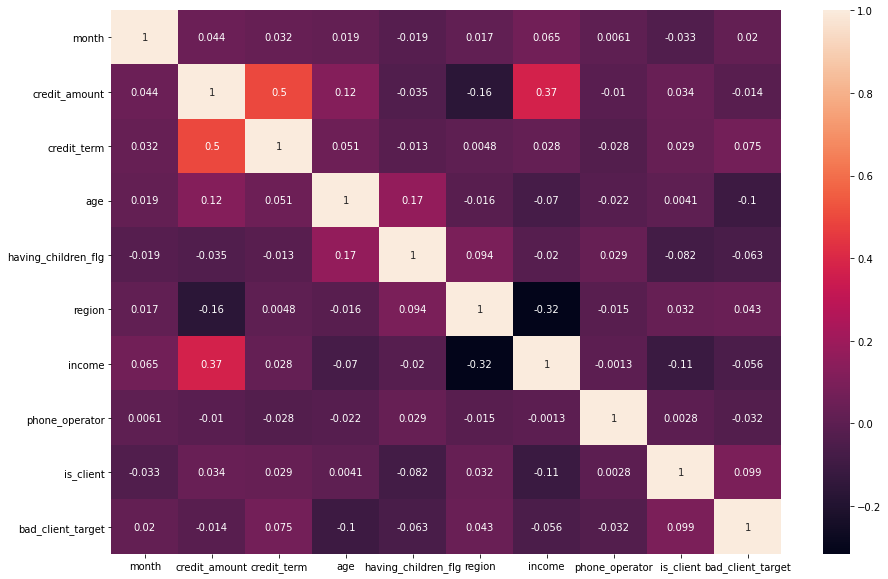

In [ ]:
figs = plt.figure(figsize=(15, 10))
sns.heatmap(client.corr(), annot=True)
plt.show()

**Comments**
1. Region and income have slight negative correlation.
2. Region and credit term have almost no correlation.
3. Phone operator and income have almost no correlation.
4. There also no correlation between month and phone operator.<br>
`To conclude we do not see any multicollinearity`

# Encoding

In [21]:
df_num = client.select_dtypes(np.number)
df_num.drop(columns=['bad_client_target'], inplace=True)
df_num.columns

Index(['month', 'credit_amount', 'credit_term', 'age', 'having_children_flg',
       'region', 'income', 'phone_operator', 'is_client'],
      dtype='object')

In [22]:
df_cat = client.select_dtypes(include='object')
df_cat.columns

Index(['sex', 'education', 'product_type', 'family_status'], dtype='object')

In [23]:
dummy_var = pd.get_dummies(df_cat, drop_first=True)
dummy_var.head(2)

,sex_male,education_Incomplete higher education,education_Incomplete secondary education,education_PhD degree,education_Secondary education,education_Secondary special education,product_type_Auto,product_type_Boats,product_type_Cell phones,product_type_Childen's goods,...,product_type_Jewelry,product_type_Medical services,product_type_Music,product_type_Repair Services,product_type_Sporting goods,product_type_Tourism,product_type_Training,product_type_Windows & Doors,family_status_Married,family_status_Unmarried
0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Function definitions

In [24]:
def plot_confusion_matrix(model, cutoff):
    y_pred_prob = model.predict(X_test)
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

    
def get_test_report(model, cutoff):
    y_pred_prob = model.predict(X_test)
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    print(classification_report(y_test, y_pred))

In [25]:
score_card = pd.DataFrame(columns=['Model Name','Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])

def update_score_card(Model_name, model, cutoff='-'):
    y_pred_prob = model.predict(X_test)
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    global score_card
    score_card = score_card.append({'Model Name':Model_name,
                                    'Probability Cutoff': cutoff,
                                    'AUC Score' : metrics.roc_auc_score(y_test, y_pred_prob),
                                    'Precision Score': metrics.precision_score(y_test, y_pred),
                                    'Recall Score': metrics.recall_score(y_test, y_pred),
                                    'Accuracy Score': metrics.accuracy_score(y_test, y_pred),
                                    'Kappa Score':metrics.cohen_kappa_score(y_test, y_pred),
                                    'f1-score': metrics.f1_score(y_test, y_pred)}, 
                                    ignore_index = True)
    
    return score_card

# Scaling

In [26]:
sc = StandardScaler()

num_scaled = sc.fit_transform(df_num)
df_num_scaled = pd.DataFrame(num_scaled, columns = df_num.columns)

X = pd.concat([df_num_scaled,dummy_var], axis=1)
Y = client['bad_client_target']

X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size = 0.3)

**Comments**<br>
As we saw in the EDA most of the features are skewed and range of values are differ by big margin. Scaling is required.

# Base Model

In [27]:
logreg_full = sm.Logit(y_train,X_train).fit(method='bfgs')
print(logreg_full.summary())

         Current function value: 0.307326
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:      bad_client_target   No. Observations:                 1206
Model:                          Logit   Df Residuals:                     1168
Method:                           MLE   Df Model:                           37
Date:                Mon, 05 Apr 2021   Pseudo R-squ.:                  0.1400
Time:                        23:39:16   Log-Likelihood:                -370.64
converged:                      False   LL-Null:                       -430.98
Covariance Type:            nonrobust   LLR p-value:                 8.345e-11
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const       

**Comments**<br>
Very little difference between log-likelihood and log-null-likelihood, meaning, no much significance of features in predicting the target variable.

In [28]:
df_odds = pd.DataFrame(np.exp(logreg_full.params), columns= ['Odds']) 
df_odds

,Odds
const,0.059117
month,1.017969
credit_amount,1.192460
credit_term,1.401019
age,0.689899
having_children_flg,1.035859
region,0.998598
income,0.832696
phone_operator,0.850735
is_client,1.342753


**How to interpret above table**
1. Odds of bad client is 0.059.
2. Month = 1.839477, it implies that the odds of getting bad client increases by a factor of 1.017969 due to one unit increase in the month, keeping other variables constant.
3. credit_amount = 1.192460, it implies that the odds of getting bad client increases by a factor of 1.192460 due to one unit increase in the credit_amount, keeping other variables constant.
4. credit_term = 1.401019, it implies that the odds of getting bad client increases by a factor of 1.401019 due to one unit increase in the credit_term, keeping other variables constant.
5. having_children_flg = 1.035859, it implies that the odds of getting bad client increases by a factor of 1.035859 due to one unit increase in the ahaving_children_flg, keeping other variables constant.
6. region = 0.998598, it implies that the odds of getting bad client increases by a factor of 0.998598 due to one unit increase in the region, keeping other variables constant.
7. income = 0.832696, it implies that the odds of getting bad client increases by a factor of 0.832696 due to one unit increase in the income, keeping other variables constant.
8. sex_male = 1.342753, it implies that the odds of getting bad client increases by a factor of 1.342753 due to one unit increase in the sex_male, keeping other variables constant.
9. education_Incomplete higher education = 0.45755, it implies that the odds of getting bad client increases by a factor of 0.45755 due to one unit increase in the education_Incomplete higher education, keeping other variables constant.<br>

and so on...


In [29]:
y_pred_prob = logreg_full.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)
youdens_table.head()

,TPR,FPR,Threshold,Difference
0,0.877193,0.428261,0.076979,0.448932
1,0.824561,0.389130,0.083843,0.435431
2,0.771930,0.336957,0.102175,0.434973
3,0.719298,0.286957,0.119671,0.432342
4,0.684211,0.256522,0.132887,0.427689


**Comments**<br>
Optimal threshold is 0.076979

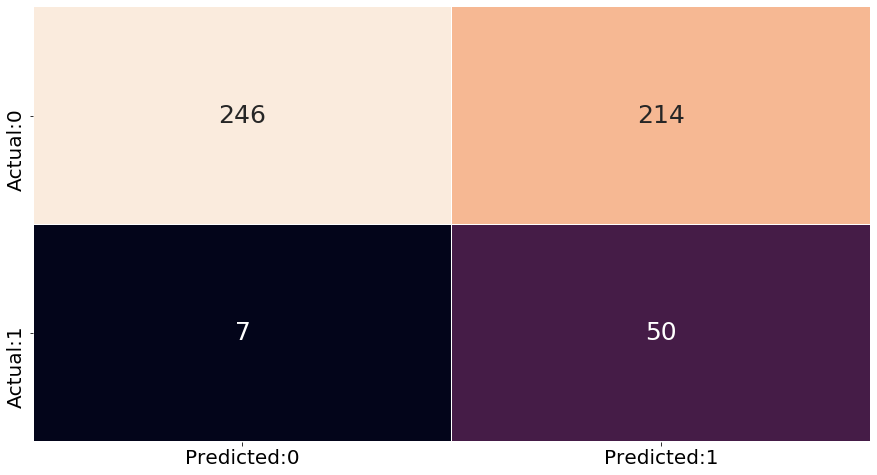

In [30]:
plot_confusion_matrix(logreg_full, 0.07)

**Comments**
1. True negative : 246.
2. True positive : 50.
3. False positive : 214.
4. False negative : 7.<br>

246 of class 0 are correctly classified and 214 instances of class 0 are incorrectly classified as class 1.<br>
7 instances of the class 1 are incorrectly classified as class 0 and 50 instances are correctly classified as class 1.


In [31]:
get_test_report(logreg_full, 0.07)

              precision    recall  f1-score   support

           0       0.97      0.53      0.69       460
           1       0.19      0.88      0.31        57

    accuracy                           0.57       517
   macro avg       0.58      0.71      0.50       517
weighted avg       0.89      0.57      0.65       517



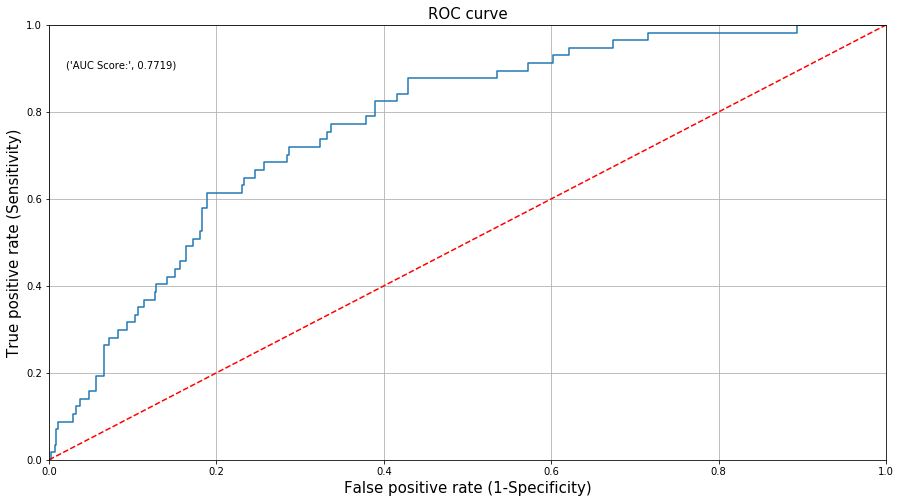

In [32]:
y_pred_prob = logreg_full.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_prob),4)))
plt.grid(True)

In [33]:
update_score_card('Logistic Regression Fullmodel',logreg_full, cutoff=0.07)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526


# Improving base model

## 1. Data balancing

In [34]:
Y.value_counts()

0    1527
1     196
Name: bad_client_target, dtype: int64

In [36]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, Y)
X_sm = pd.DataFrame(X_sm, columns=X.columns)
y_sm = pd.DataFrame(y_sm, columns=['bad_client_target'])
y_sm['bad_client_target'].value_counts()

1    1527
0    1527
Name: bad_client_target, dtype: int64

## 2. Function definitions

In [37]:
def plot_roc(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC curve ', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x = 0.82, y = 0.3, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))
    plt.grid(True)
    
def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    
def get_train_report(model):
    train_pred = model.predict(X_train)
    return(classification_report(y_train, train_pred))

def get_test_report(model):
    test_pred = model.predict(X_test)
    return(classification_report(y_test, test_pred))

def update_score_card(Model_name,model,cutoff="-"):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    global score_card
    
    score_card = score_card.append({'Model Name':Model_name,
                                    'Probability Cutoff': cutoff,
                                    'AUC Score' : metrics.roc_auc_score(y_test, y_pred_prob),
                                    'Precision Score': metrics.precision_score(y_test, y_pred),
                                    'Recall Score': metrics.recall_score(y_test, y_pred),
                                    'Accuracy Score': metrics.accuracy_score(y_test, y_pred),
                                    'Kappa Score':metrics.cohen_kappa_score(y_test, y_pred),
                                    'f1-score': metrics.f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

    return score_card

# Logistic regression (Improved)

In [38]:
X = pd.concat([df_num_scaled,dummy_var], axis=1)
Y = client['bad_client_target']
smote = SMOTE(random_state=42)
X_sm, Y_sm = smote.fit_resample(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, random_state = 10, test_size = 0.3)

lr = LogisticRegression()
lr_full = lr.fit(X_train, y_train)

In [39]:
y_pred_prob = lr_full.predict_proba(X_test)[:,1:]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)
youdens_table.head()

,TPR,FPR,Threshold,Difference
0,0.877462,0.210870,0.513331,0.666592
1,0.884026,0.221739,0.492355,0.662287
2,0.866521,0.208696,0.524459,0.657825
3,0.888403,0.232609,0.482129,0.655794
4,0.877462,0.221739,0.497564,0.655723


**Comments**<br>
Optimal threshold is 0.51

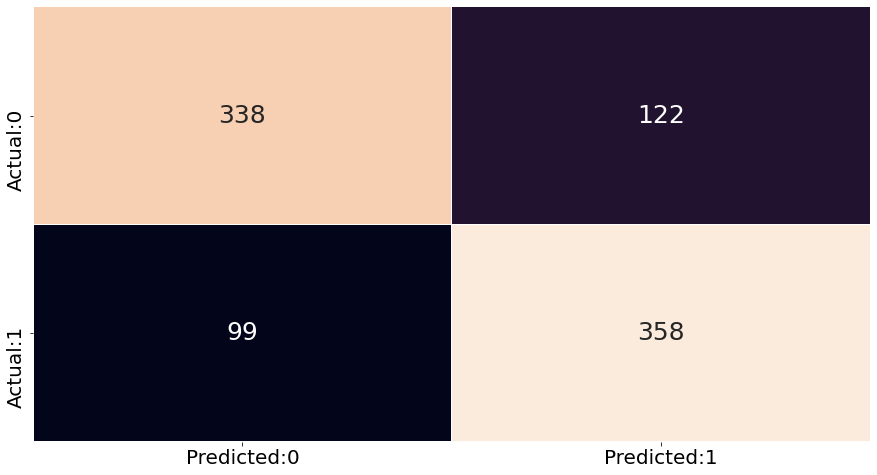

In [ ]:
plot_confusion_matrix(lr_full)

**Comments**
1. True negative : 338.
2. True positive : 358.
3. False positive : 122.
4. False negative : 99.<br>

338 of class 0 are correctly classified and 122 instances of class 0 are incorrectly classified as class 1.<br>
99 instances of the class 1 are incorrectly classified as class 0 and 358 instances are correctly classified as class 1.

In [40]:
print(get_test_report(lr_full))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       460
           1       0.80      0.88      0.84       457

    accuracy                           0.83       917
   macro avg       0.83      0.83      0.83       917
weighted avg       0.83      0.83      0.83       917



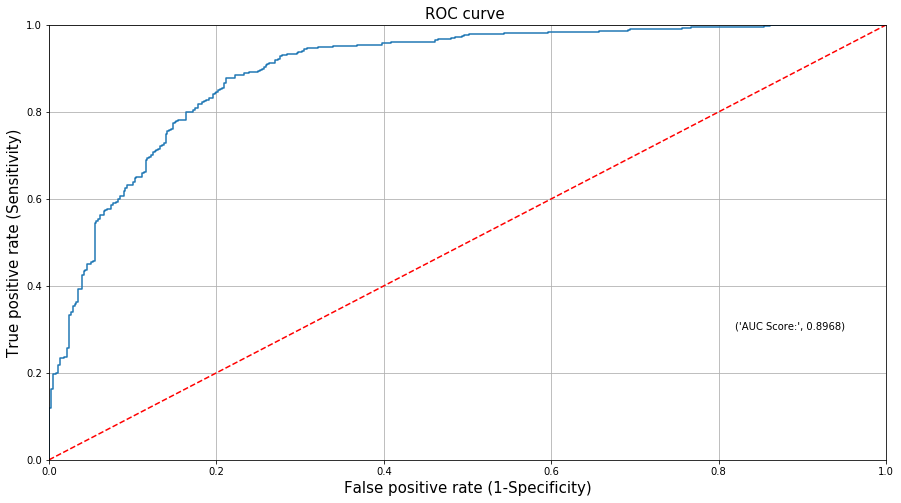

In [41]:
plot_roc(lr_full)

In [42]:
update_score_card('Logistic Regression(balanced data)',lr_full,0.51)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288


# Feature Selection

In [46]:
from sklearn.feature_selection import RFE
accuracy_score=[]
for i in range(1,39):
    X_train_rfe = X_train
    X_test_rfe = X_test
    logreg = LogisticRegression()
    rfe_model = RFE(estimator = logreg, n_features_to_select = i)
    rfe_model = rfe_model.fit(X_train_rfe, y_train)
    feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
    signi_feat_rfe = feat_index[feat_index==1].index
    accuracy_score.append(rfe_model.score(X_train_rfe,y_train))

lis_acc={(i+1,np.round(accuracy_score[i],4))  for i in range(0,38)}
lis_acc

{(1, 0.5512),
 (2, 0.5779),
 (3, 0.6266),
 (4, 0.6355),
 (5, 0.6453),
 (6, 0.6575),
 (7, 0.6654),
 (8, 0.6738),
 (9, 0.6874),
 (10, 0.7861),
 (11, 0.7941),
 (12, 0.7983),
 (13, 0.8016),
 (14, 0.8053),
 (15, 0.8095),
 (16, 0.8114),
 (17, 0.8114),
 (18, 0.8114),
 (19, 0.8114),
 (20, 0.8133),
 (21, 0.8124),
 (22, 0.8124),
 (23, 0.8124),
 (24, 0.8114),
 (25, 0.8133),
 (26, 0.8222),
 (27, 0.8226),
 (28, 0.8269),
 (29, 0.8269),
 (30, 0.8241),
 (31, 0.8283),
 (32, 0.8283),
 (33, 0.8306),
 (34, 0.8306),
 (35, 0.8283),
 (36, 0.8287),
 (37, 0.8283),
 (38, 0.8283)}

# Logistic regression (RFE)

In [47]:
logreg = LogisticRegression()
rfe_model = RFE(estimator = logreg, n_features_to_select = 33)
rfe_model = rfe_model.fit(X_train, y_train)
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train.columns)
signi_feat_rfe = feat_index[feat_index==1].index
print(signi_feat_rfe)

Index(['credit_term', 'age', 'income', 'phone_operator', 'is_client',
       'sex_male', 'education_Incomplete higher education',
       'education_Incomplete secondary education', 'education_PhD degree',
       'education_Secondary education',
       'education_Secondary special education', 'product_type_Auto',
       'product_type_Boats', 'product_type_Cell phones',
       'product_type_Childen's goods', 'product_type_Clothing',
       'product_type_Computers', 'product_type_Construction Materials',
       'product_type_Cosmetics and beauty services', 'product_type_Fitness',
       'product_type_Furniture', 'product_type_Garden equipment',
       'product_type_Household appliances', 'product_type_Jewelry',
       'product_type_Medical services', 'product_type_Music',
       'product_type_Repair Services', 'product_type_Sporting goods',
       'product_type_Tourism', 'product_type_Training',
       'product_type_Windows & Doors', 'family_status_Married',
       'family_status_Unmarrie

In [55]:
X_train = X_train[signi_feat_rfe]
X_test = X_test[signi_feat_rfe]
lr = LogisticRegression()
lr_signi = lr.fit(X_signi, y_train) 

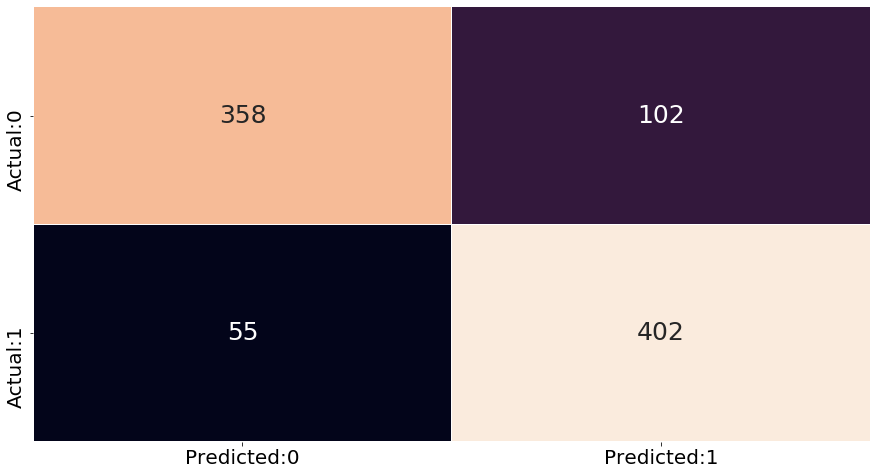

In [56]:
plot_confusion_matrix(lr_signi)

**Comments**
1. True negative : 358.
2. True positive : 402.
3. False positive : 102.
4. False negative : 55.<br>

358 of class 0 are correctly classified and 102 instances of class 0 are incorrectly classified as class 1.<br>
55 instances of the class 1 are incorrectly classified as class 0 and 402 instances are correctly classified as class 1.

In [57]:
print(get_test_report(lr_signi))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       460
           1       0.80      0.88      0.84       457

    accuracy                           0.83       917
   macro avg       0.83      0.83      0.83       917
weighted avg       0.83      0.83      0.83       917



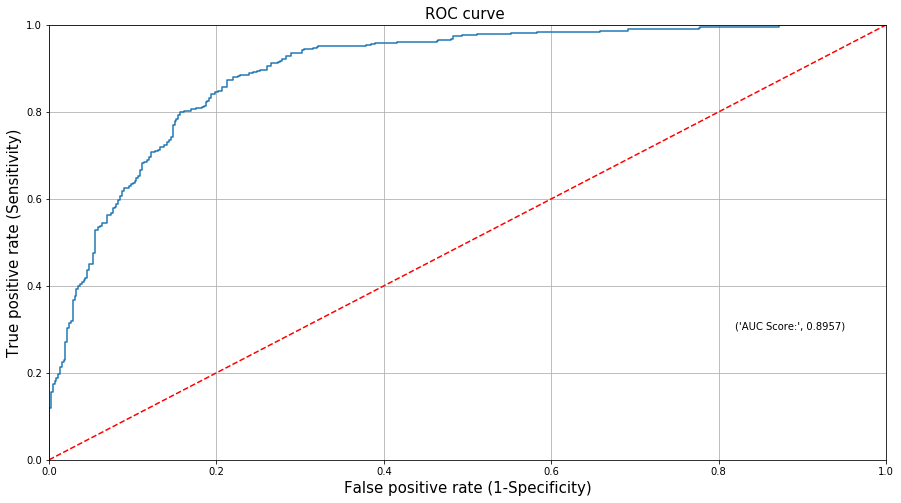

In [58]:
plot_roc(lr_signi)

In [59]:
update_score_card('Logistic RFE Regression',lr_signi)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629


# Naive Bayes

In [60]:
gnb = GaussianNB()
gnb_model = gnb.fit(X_train, y_train)

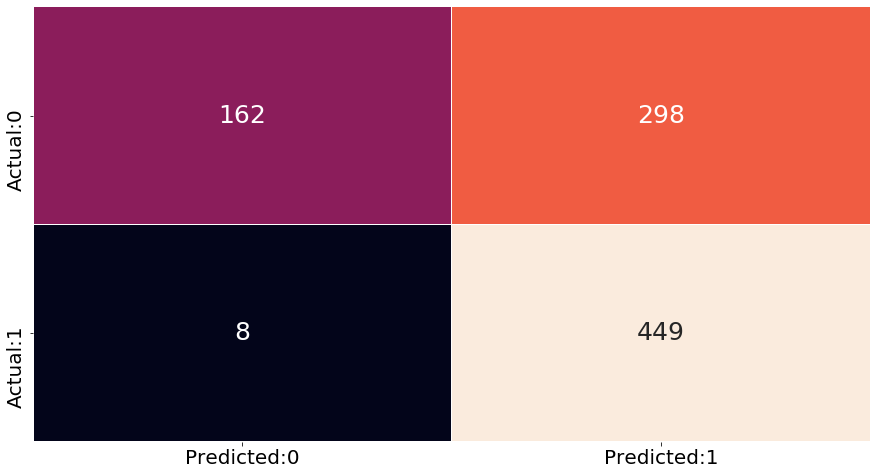

In [61]:
plot_confusion_matrix(gnb_model)

**Comments**
1. True negative : 162.
2. True positive : 449.
3. False positive : 298.
4. False negative : 8.<br>

162 of class 0 are correctly classified and 298 instances of class 0 are incorrectly classified as class 1.<br>
8 instance of the class 1 are incorrectly classified as class 0 and 449 instances are correctly classified as class 1.

In [62]:
print(get_test_report(gnb_model))

              precision    recall  f1-score   support

           0       0.95      0.35      0.51       460
           1       0.60      0.98      0.75       457

    accuracy                           0.67       917
   macro avg       0.78      0.67      0.63       917
weighted avg       0.78      0.67      0.63       917



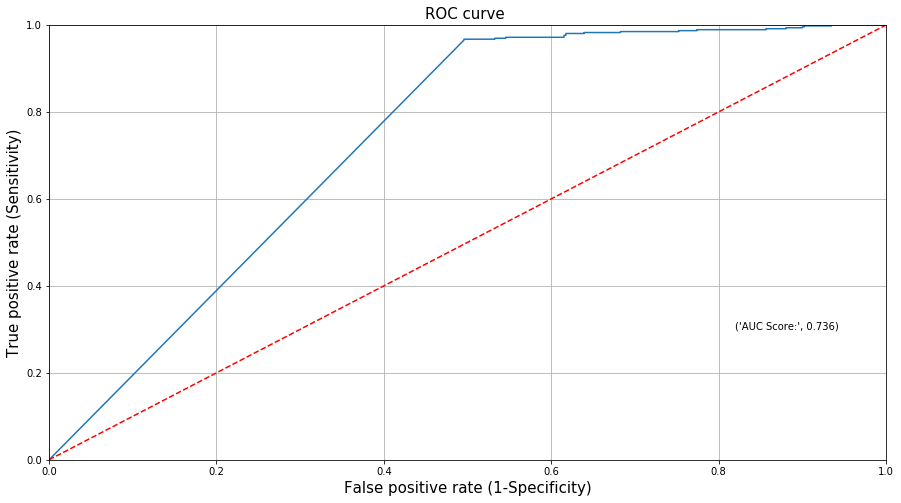

In [63]:
plot_roc(gnb_model)

In [64]:
update_score_card('Gaussian Naive Bayes',gnb_model)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847


# K-Nearest Neighbor

In [65]:
tuned_paramaters = [{'metric': ['euclidean', 'minkowski'],
                     'n_neighbors': [2, 3, 4, 5, 6, 8, 10]}]
 
knn_classification = KNeighborsClassifier()

rf_grid = GridSearchCV(estimator = knn_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 5)

rf_grid_model = rf_grid.fit(X_train, y_train)
rf_grid_model.best_params_

{'metric': 'euclidean', 'n_neighbors': 2}

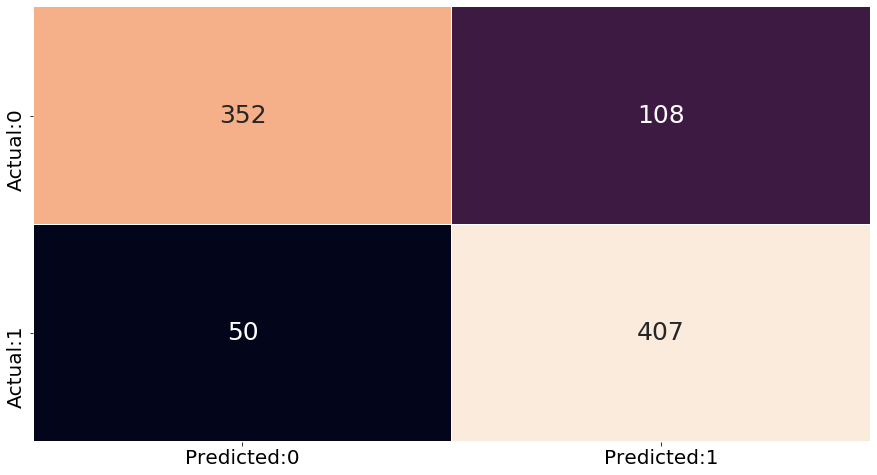

In [66]:
knn_classification = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 2)
knn = knn_classification.fit(X_train, y_train)
plot_confusion_matrix(knn)

### **Comments**
1. True negative : 352.
2. True positive socre is 407.
3. False positive socre is 108.
4. False negative socre is 50.<br>

352 of class 0 are correctly classified and 108 instances of class 0 are incorrectly classified as class 1.<br>
50 instances of the class 1 are incorrectly classified as class 0 and 407 instances are correctly classified as class 1.

In [67]:
print(get_test_report(knn))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       460
           1       0.79      0.89      0.84       457

    accuracy                           0.83       917
   macro avg       0.83      0.83      0.83       917
weighted avg       0.83      0.83      0.83       917



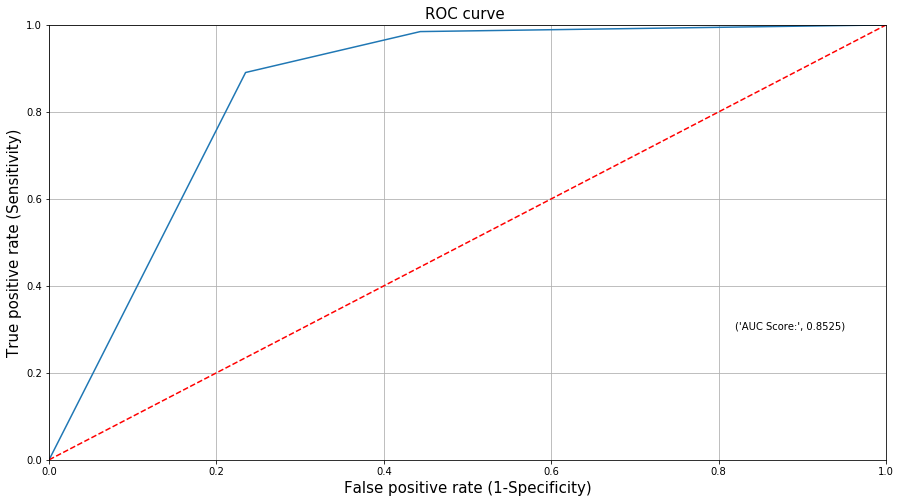

In [68]:
plot_roc(knn)

In [69]:
update_score_card('KNN classifier',knn)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847
4,KNN classifier,-,0.852488,0.790291,0.890591,0.827699,0.655537,0.837449


# Decision Tree

In [70]:
decision_tree_classification  = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  min_samples_split = 5,
                                  max_leaf_nodes = 6,
                                  random_state = 10)

decision_tree = decision_tree_classification.fit(X_train, y_train)

train_report = get_train_report(decision_tree)
print('Train data:\n', train_report)

test_report = get_test_report(decision_tree)
print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       0.84      0.57      0.68      1067
           1       0.67      0.89      0.77      1070

    accuracy                           0.73      2137
   macro avg       0.76      0.73      0.72      2137
weighted avg       0.76      0.73      0.72      2137

Test data:
               precision    recall  f1-score   support

           0       0.83      0.55      0.66       460
           1       0.66      0.89      0.76       457

    accuracy                           0.72       917
   macro avg       0.75      0.72      0.71       917
weighted avg       0.75      0.72      0.71       917



tuned_paramaters = [{'criterion': ['entropy', 'gini'], 
                     'max_depth': range(2, 10),
                     'min_samples_split': range(2,10),
                     'max_leaf_nodes': range(1, 10)}]

decision_tree_classification = DecisionTreeClassifier(random_state = 10)
tree_grid = GridSearchCV(estimator = decision_tree_classification, 
                         param_grid = tuned_paramaters, 
                         cv = 5)


tree_grid_model = tree_grid.fit(X_train, y_train)
print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

In [71]:
decision_tree_classification  = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 6,
                                  min_samples_split = 2,
                                  max_leaf_nodes = 8,
                                  random_state = 10)

decision_tree = decision_tree_classification.fit(X_train, y_train)

train_report = get_train_report(decision_tree)
print('Train data:\n', train_report)

test_report = get_test_report(decision_tree)
print('Test data:\n', test_report)


Train data:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1067
           1       0.75      0.80      0.78      1070

    accuracy                           0.77      2137
   macro avg       0.77      0.77      0.77      2137
weighted avg       0.77      0.77      0.77      2137

Test data:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       460
           1       0.74      0.80      0.77       457

    accuracy                           0.76       917
   macro avg       0.76      0.76      0.76       917
weighted avg       0.76      0.76      0.76       917



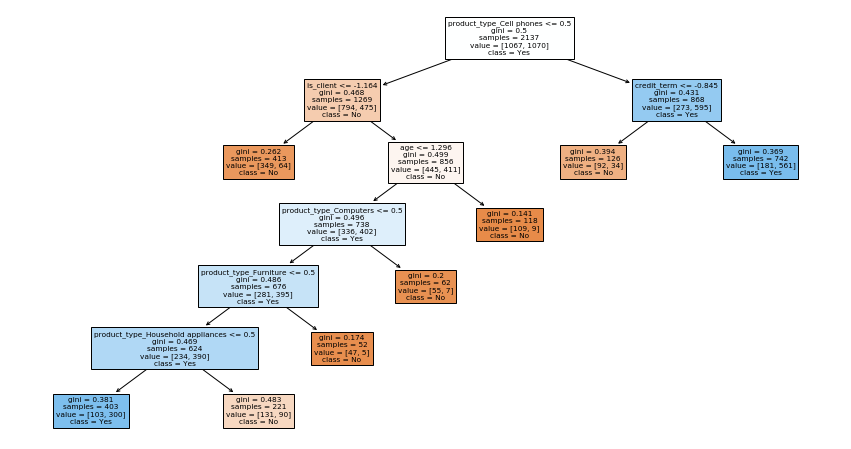

In [72]:
labels = X_train.columns
from sklearn import tree
tree.plot_tree(decision_tree,filled=True, feature_names = labels, class_names = ["No","Yes"])
plt.show()

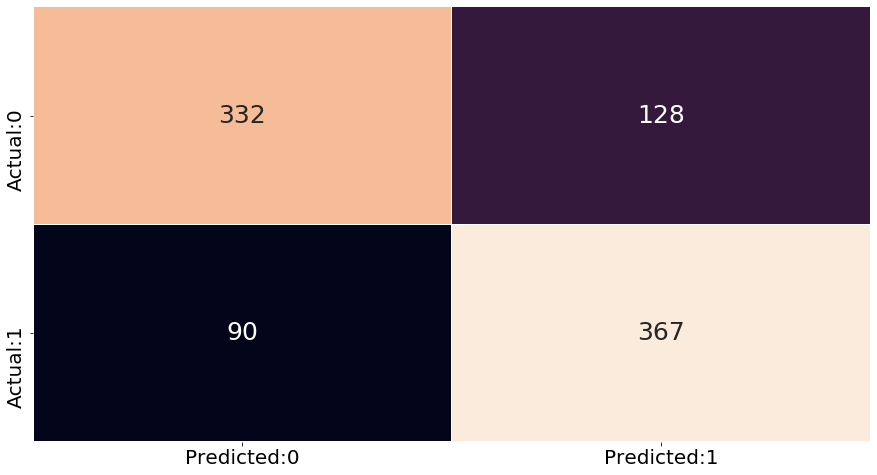

In [73]:
plot_confusion_matrix(decision_tree)

**Comments**
1. True negative : 332.
2. True positive : 367.
3. False positive : 128.
4. False negative : 90.<br>

332 of class 0 are correctly classified and 128 instances of class 0 are incorrectly classified as class 1.<br>
90 instances of the class 1 are incorrectly classified as class 0 and 367 instances are correctly classified as class 1.

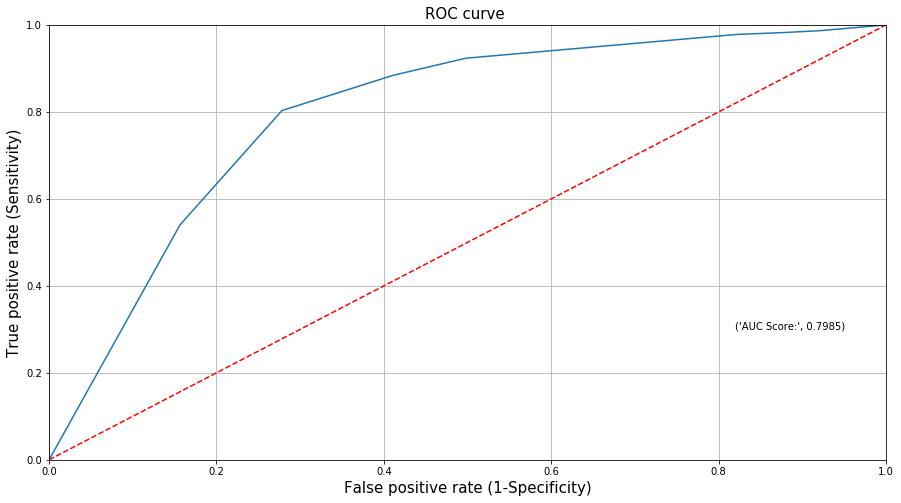

In [74]:
plot_roc(decision_tree)

In [75]:
update_score_card('Decision Tree',decision_tree)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847
4,KNN classifier,-,0.852488,0.790291,0.890591,0.827699,0.655537,0.837449
5,Decision Tree,-,0.798459,0.741414,0.803063,0.762268,0.524660,0.771008


# Random Forest

In [76]:
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)
rf_model = rf_classification.fit(X_train, y_train)

train_report = get_train_report(rf_model)
print('Train data:\n', train_report)

test_report = get_test_report(rf_model)
print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1067
           1       1.00      1.00      1.00      1070

    accuracy                           1.00      2137
   macro avg       1.00      1.00      1.00      2137
weighted avg       1.00      1.00      1.00      2137

Test data:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       460
           1       0.91      0.89      0.90       457

    accuracy                           0.90       917
   macro avg       0.90      0.90      0.90       917
weighted avg       0.90      0.90      0.90       917



tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [10, 30, 50, 70, 90],
                     'max_depth': [10, 15, 20],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 5, 8, 11],
                     'min_samples_leaf': [1, 5, 9],
                     'max_leaf_nodes': [2, 5, 8, 11]}]

random_forest_classification = RandomForestClassifier(random_state = 10)

rf_grid = GridSearchCV(estimator = random_forest_classification, 
                       param_grid = tuned_paramaters, 
                       cv = 5)


rf_grid_model = rf_grid.fit(X_train, y_train)

print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

In [77]:
rf_model = RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 90,
                                  max_depth = 10,
                                  max_features = 'sqrt',
                                  max_leaf_nodes = 11,
                                  min_samples_leaf = 1,
                                  min_samples_split = 8,
                                  random_state = 10)

rf_model = rf_model.fit(X_train, y_train)
train_report = get_train_report(rf_model)
print('Train data:\n', train_report)

test_report = get_test_report(rf_model)
print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1067
           1       0.81      0.85      0.83      1070

    accuracy                           0.83      2137
   macro avg       0.83      0.83      0.83      2137
weighted avg       0.83      0.83      0.83      2137

Test data:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       460
           1       0.82      0.85      0.83       457

    accuracy                           0.83       917
   macro avg       0.83      0.83      0.83       917
weighted avg       0.83      0.83      0.83       917



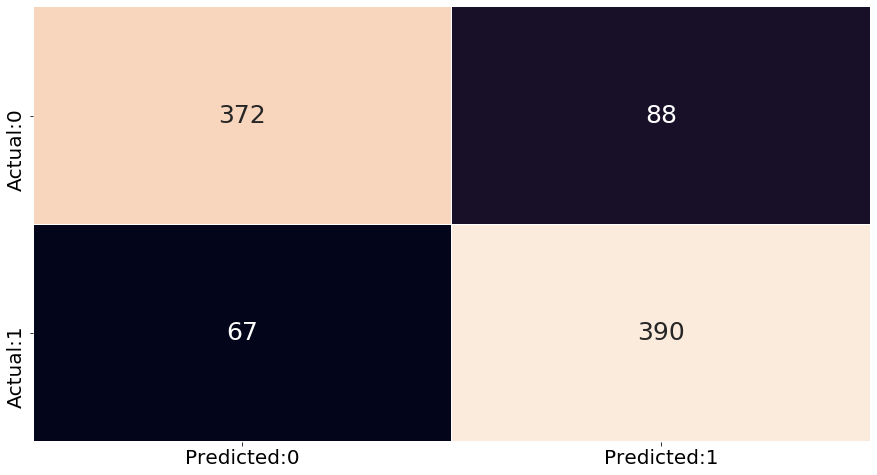

In [78]:
plot_confusion_matrix(rf_model)

**Comments**
1. True negative : 372.
2. True positive : 390.
3. False positive : 88.
4. False negative : 67.<br>

372 of class 0 are correctly classified and 88 instances of class 0 are incorrectly classified as class 1.<br>
67 instances of the class 1 are incorrectly classified as class 0 and 390 instances are correctly classified as class 1.

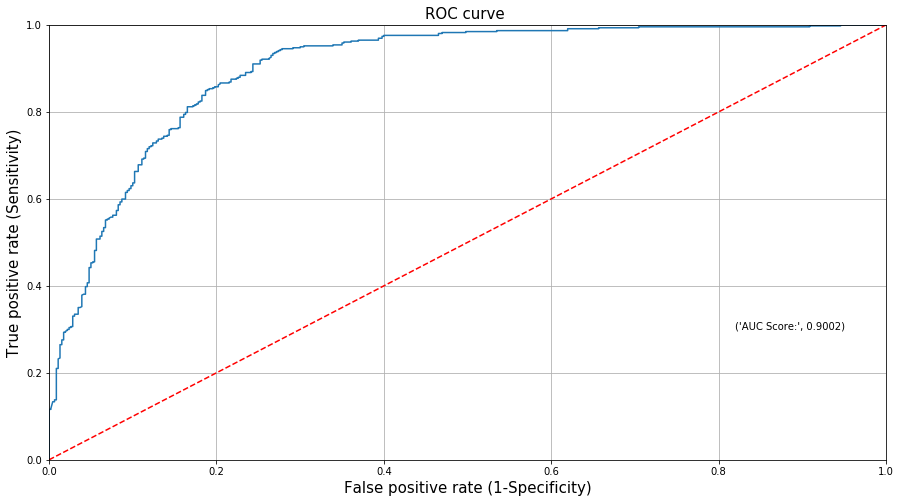

In [79]:
plot_roc(rf_model)

In [80]:
update_score_card('Random Forest',rf_model)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847
4,KNN classifier,-,0.852488,0.790291,0.890591,0.827699,0.655537,0.837449
5,Decision Tree,-,0.798459,0.741414,0.803063,0.762268,0.524660,0.771008
6,Random Forest,-,0.900209,0.815900,0.853392,0.830971,0.661988,0.834225


# Boosting: XGBoost

In [81]:
xgb_model = XGBClassifier(max_depth = 10, gamma = 1)

xgb_model.fit(X_train, y_train)

train_report = get_train_report(xgb_model)
print('Train data:\n', train_report)

test_report = get_test_report(xgb_model)
print('Test data:\n', test_report)

[00:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1067
           1       0.99      0.98      0.98      1070

    accuracy                           0.98      2137
   macro avg       0.98      0.98      0.98      2137
weighted avg       0.98      0.98      0.98      2137

Test data:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       460
           1       0.92      0.92      0.92       457

    accuracy                           0.92       917
   macro avg       0.92      0.92      0.92       917
weighted avg       0.92      0.92      0.92       917



tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                     'max_depth': range(3,10),
                     'gamma': [0, 1, 2, 3, 4]}

xgb_model = XGBClassifier()
xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = tuning_parameters, cv = 3, scoring = 'roc_auc')

xgb_grid.fit(X_train, y_train)

print('Best parameters for XGBoost classifier: ', xgb_grid.best_params_, '\n')

In [82]:
xgb_grid_model = XGBClassifier(learning_rate = 0.3,
                               max_depth = 4,
                              gamma = 0)

xgb_model = xgb_grid_model.fit(X_train, y_train)

train_report = get_train_report(xgb_model)
print('Train data:\n', train_report)

test_report = get_test_report(xgb_model)
print('Test data:\n', test_report)

[00:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train data:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1067
           1       0.97      0.95      0.96      1070

    accuracy                           0.96      2137
   macro avg       0.96      0.96      0.96      2137
weighted avg       0.96      0.96      0.96      2137

Test data:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       460
           1       0.92      0.91      0.92       457

    accuracy                           0.92       917
   macro avg       0.92      0.92      0.92       917
weighted avg       0.92      0.92      0.92       917



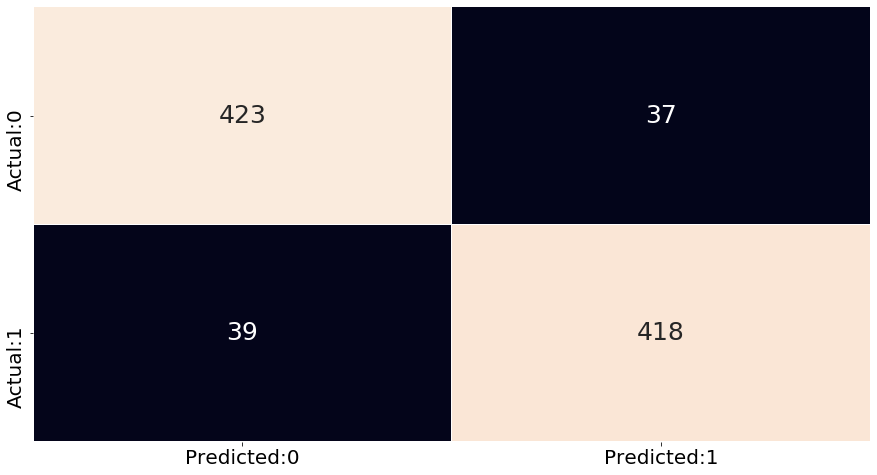

In [83]:
plot_confusion_matrix(xgb_model)

**Comments**
1. True negative socre is 423.
2. True positive socre is 418.
3. False positive socre is 37.
4. False negative socre is 39.<br>

423 of class 0 are correctly classified and only 37 instances of class 0 are incorrectly classified as class 1.<br>
39 instances of the class 1 are incorrectly classified as class 0 and 418 instances are correctly classified as class 1.

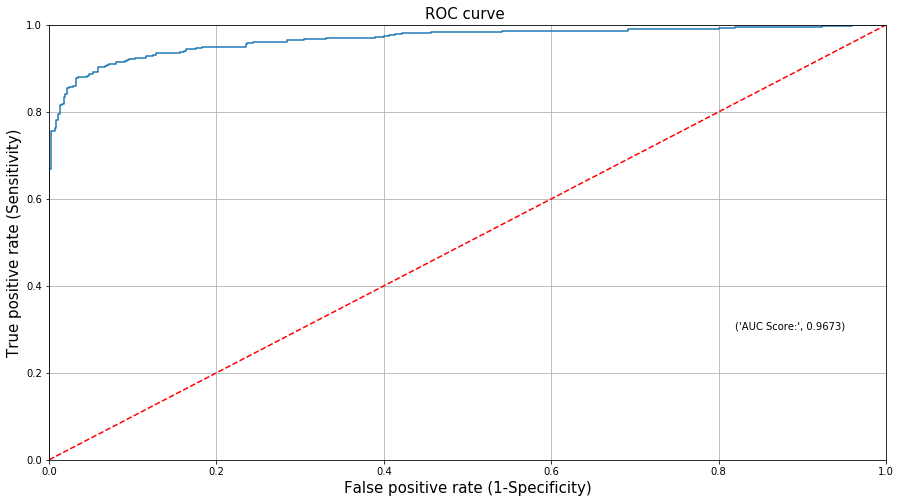

In [84]:
plot_roc(xgb_model)

In [85]:
update_score_card('XGBoost',xgb_model)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847
4,KNN classifier,-,0.852488,0.790291,0.890591,0.827699,0.655537,0.837449
5,Decision Tree,-,0.798459,0.741414,0.803063,0.762268,0.524660,0.771008
6,Random Forest,-,0.900209,0.815900,0.853392,0.830971,0.661988,0.834225
7,XGBoost,-,0.967296,0.918681,0.914661,0.917121,0.834238,0.916667


# Stacking

In [86]:
base_learners = [('Decision Tree Model', DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 6,
                                  min_samples_split = 2,
                                  max_leaf_nodes = 8,
                                  random_state = 10)),
                 ('Random Forest model',RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 90,
                                  max_depth = 10,
                                  min_samples_split = 8,
                                  random_state = 10))]

stack_model = StackingClassifier(estimators = base_learners, final_estimator = XGBClassifier())
stack_model.fit(X_train, y_train)

train_report = get_train_report(stack_model)
print('Train data:\n', train_report)

test_report = get_test_report(stack_model)
print('Test data:\n', test_report)

[00:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train data:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1067
           1       0.91      0.91      0.91      1070

    accuracy                           0.91      2137
   macro avg       0.91      0.91      0.91      2137
weighted avg       0.91      0.91      0.91      2137

Test data:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87       460
           1       0.87      0.87      0.87       457

    accuracy                           0.87       917
   macro avg       0.87      0.87      0.87       917
weighted avg       0.87      0.87      0.87       917



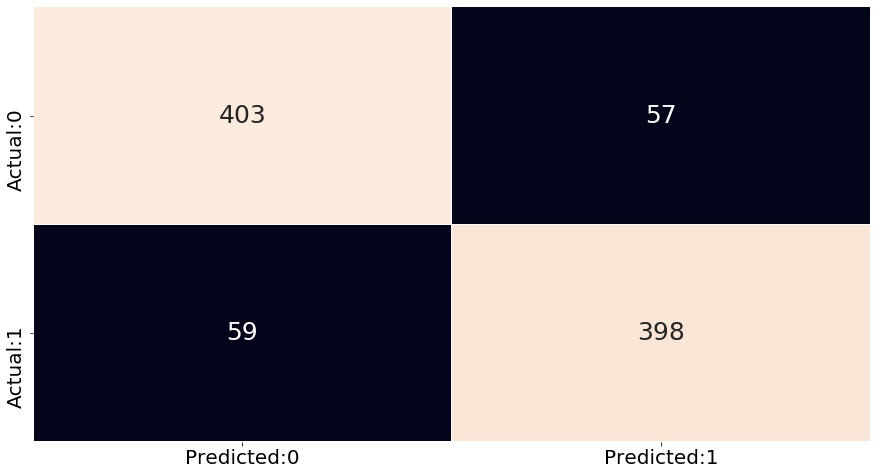

In [87]:
plot_confusion_matrix(stack_model)

**Comments**
1. True negative socre is 403.
2. True positive socre is 398.
3. False positive socre is 57.
4. False negative socre is 59.<br>

403 of class 0 are correctly classified and 57 instances of class 0 are incorrectly classified as class 1.<br>
59 instances of the class 1 are incorrectly classified as class 0 and 398 instances are correctly classified as class 1.

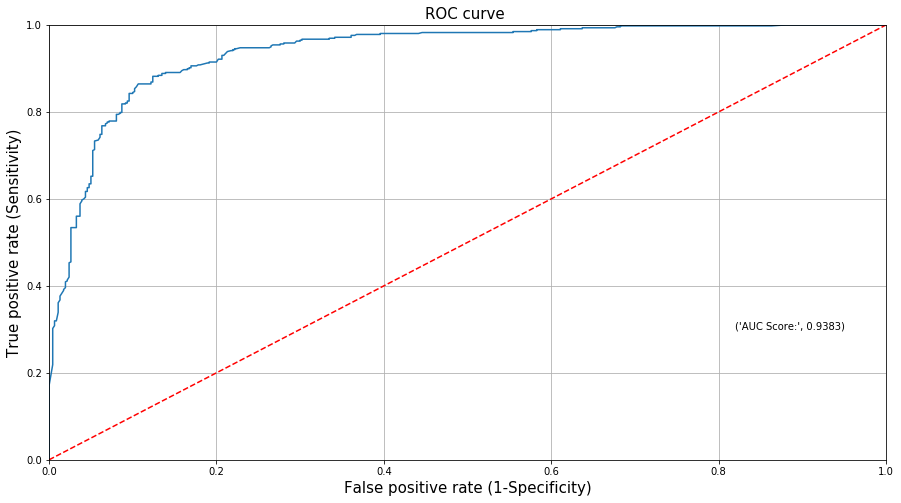

In [88]:
plot_roc(stack_model)

In [89]:
update_score_card('Stacked model with final estimator as XGBoost',stack_model)

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.07,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.51,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847
4,KNN classifier,-,0.852488,0.790291,0.890591,0.827699,0.655537,0.837449
5,Decision Tree,-,0.798459,0.741414,0.803063,0.762268,0.524660,0.771008
6,Random Forest,-,0.900209,0.815900,0.853392,0.830971,0.661988,0.834225
7,XGBoost,-,0.967296,0.918681,0.914661,0.917121,0.834238,0.916667
8,Stacked model with final estimator as XGBoost,-,0.938286,0.874725,0.870897,0.873501,0.746995,0.872807


In [90]:
score_card.style.highlight_max(['AUC Score'], 'gray')

,Model Name,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,Logistic Regression Fullmodel,0.070000,0.771854,0.189394,0.877193,0.572534,0.159015,0.311526
1,Logistic Regression(balanced data),0.510000,0.896784,0.798805,0.877462,0.828790,0.657685,0.836288
2,Logistic RFE Regression,-,0.895714,0.797619,0.879650,0.828790,0.657690,0.836629
3,Gaussian Naive Bayes,-,0.735991,0.601071,0.982495,0.666303,0.333977,0.745847
4,KNN classifier,-,0.852488,0.790291,0.890591,0.827699,0.655537,0.837449
5,Decision Tree,-,0.798459,0.741414,0.803063,0.762268,0.524660,0.771008
6,Random Forest,-,0.900209,0.815900,0.853392,0.830971,0.661988,0.834225
7,XGBoost,-,0.967296,0.918681,0.914661,0.917121,0.834238,0.916667
8,Stacked model with final estimator as XGBoost,-,0.938286,0.874725,0.870897,0.873501,0.746995,0.872807


# Conclusion
As per the table above XG Boost model gives the best results with an AUC score of 97% and an accuracy score of 92% . However, scores are not only the criteria to decide the best model we also have to take overfitting/underfitting into consideration. XGBoost of course gives best score but is slightly overfitted. Stacked model being 1% less accurate is better balanced than XGBoost and hence, best model is concluded as Stacked model with final estimator as XGBoost.